In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

EPOCHS = 100
HL_SIZE = 32
LR = 0.001
BATCH_SIZE = 16384

In [2]:
class NN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 1)  # output logits (no sigmoid)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out  # logits

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NN(input_size=7, hidden_size=HL_SIZE).to(device)

In [3]:
model.load_state_dict(torch.load('model.pth'))
print("Model loaded from model.pth")

Model loaded from model.pth


In [ ]:
data = np.loadtxt('data.txt', delimiter=',', dtype=np.float32)
filtered_data = data[data[:, 0] < 4] # disallow high depth stuff
X, y = torch.tensor(filtered_data[:, :-1], dtype=torch.float32), torch.tensor(filtered_data[:, -1], dtype=torch.float32).unsqueeze(1)

train_loader = DataLoader(TensorDataset(X, y), batch_size=BATCH_SIZE, shuffle=True)

pos = (y == 1).sum().item()
neg = (y == 0).sum().item()
pos_weight = torch.tensor([neg / max(pos, 1)], device=device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)


In [ ]:
# Training loop
model.train()
for epoch in range(EPOCHS):
    loss_sum = 0
    idx = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model(inputs)  # raw scores
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        loss_sum += loss.item()
        idx += 1
        if idx % 100 == 0:
            print(f"Epoch [{epoch+1}/{EPOCHS}], Step [{idx}/{len(train_loader)}], Loss: {loss_sum/idx:.4f}")
    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {loss_sum/len(train_loader):.4f}")
    if epoch % 5 == 0:
        torch.save(model.state_dict(), f'model_epoch_{epoch}.pth')
        print(f"Model saved to model_epoch_{epoch}.pth")



In [29]:
# Model evaluation
data2 = np.loadtxt('eval.txt', delimiter=',', dtype=np.float32)
filtered_data2 = data2[data2[:, 0] < 4] # disallow high depth stuff
X, y = torch.tensor(filtered_data2[:, :-1], dtype=torch.float32), torch.tensor(filtered_data2[:, -1], dtype=torch.float32).unsqueeze(1)

val_loader = DataLoader(TensorDataset(X, y), batch_size=BATCH_SIZE, shuffle=True)

tot_tp, tot_tn, tot_fp, tot_fn = 0, 0, 0, 0
model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        logits = model(inputs)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.9).float()
        # Compute metrics here
        tp = ((preds == 1) & (labels == 1)).sum().item()
        tn = ((preds == 0) & (labels == 0)).sum().item()
        fp = ((preds == 1) & (labels == 0)).sum().item()
        fn = ((preds == 0) & (labels == 1)).sum().item()
        # Print or store the metrics as needed
        tot_tp += tp
        tot_tn += tn
        tot_fp += fp
        tot_fn += fn

print(f"TP: {tot_tp}, TN: {tot_tn}, FP: {tot_fp}, FN: {tot_fn}")
print(f"Overall accuracy: {(tot_tp + tot_tn) / (tot_tp + tot_tn + tot_fp + tot_fn):.4f}")
print(f"Cutoff rate: {tot_tp / (tot_tp + tot_fn):.4f}")
print(f"False cutoff rate: {tot_fp / (tot_fp + tot_tn):.4f}")
print(f"Trustworthiness: {tot_tp / (tot_tp + tot_fp):.4f}")

TP: 484801, TN: 1035283, FP: 6352, FN: 3701780
Overall accuracy: 0.2907
Cutoff rate: 0.1158
False cutoff rate: 0.0061
Trustworthiness: 0.9871


In [15]:
fc1_w = model.fc1.weight.detach().cpu().numpy()
fc1_b = model.fc1.bias.detach().cpu().numpy()
fc2_w = model.fc2.weight.detach().cpu().numpy()
fc2_b = model.fc2.bias.detach().cpu().numpy()

# print the raw float weights in c-style array to be copy pasted
print("constexpr float fc1_w[" + str(fc1_w.shape[0]) + "][" + str(fc1_w.shape[1]) + "] = {")
for i, row in enumerate(fc1_w):
    print("  {" + ", ".join(f"{w:.6f}f" for w in row) + "}" + ("," if i < len(fc1_w) - 1 else ""))
print("};")
print("constexpr float fc1_b[] = {" + ", ".join(f"{b}" for b in fc1_b) + "};")
print("constexpr float fc2_w[" + str(fc2_w.shape[0]) + "][" + str(fc2_w.shape[1]) + "] = {")
for i, row in enumerate(fc2_w):
    print("  {" + ", ".join(f"{w:.6f}f" for w in row) + "}" + ("," if i < len(fc2_w) - 1 else ""))
print("};")
print("constexpr float fc2_b = " + ", ".join(f"{b}" for b in fc2_b) + ";")

constexpr float fc1_w[32][7] = {
  {-0.142832f, 0.257207f, 3.059942f, 2.634154f, -0.280495f, -0.291688f, -0.338926f},
  {2.014827f, 0.003721f, 7.907294f, -3.755454f, -0.046315f, -1.958439f, -0.009919f},
  {-0.305199f, -0.075899f, -2.393071f, 0.447503f, -0.010461f, 0.207258f, 0.114630f},
  {-0.855188f, -0.245207f, 1.158329f, -5.867863f, 0.273297f, 1.084720f, 0.312102f},
  {-3.321608f, 0.032172f, 3.490289f, 3.068175f, -0.034605f, 3.352406f, -0.116044f},
  {-0.514411f, -0.204998f, -0.000549f, -5.308782f, 0.207224f, 0.989027f, 0.180521f},
  {-3.171893f, -0.007797f, 0.546640f, -5.410606f, -0.009987f, -3.278243f, 0.005597f},
  {-0.038320f, -0.356003f, -0.210976f, -3.554320f, 0.069527f, -0.853302f, -0.122736f},
  {0.174251f, 0.183640f, 0.764978f, 5.484465f, -0.029347f, 0.479122f, 0.061596f},
  {1.197889f, -0.002775f, 7.744094f, -20.791843f, 0.042538f, 0.414730f, 0.000301f},
  {0.186771f, 0.190327f, -0.823688f, -0.061686f, -0.135967f, 2.359247f, 0.346188f},
  {-0.522338f, 0.056001f, -2.260973f

## Data visualization stuff

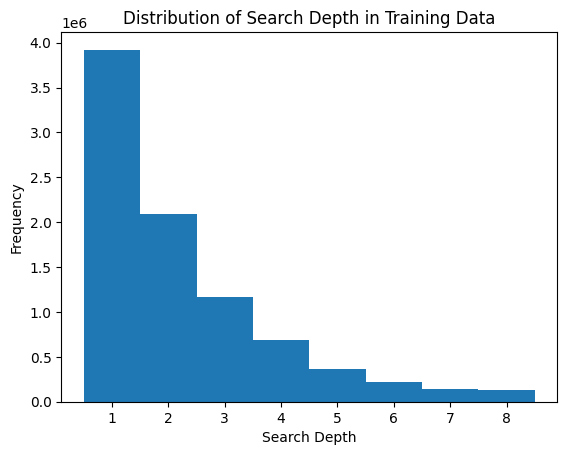

In [27]:
# distribution of depth in training data
import matplotlib.pyplot as plt

depths = data[:, 0]
plt.hist(depths, bins=range(int(depths.min()), 10), align='left')
plt.xlabel('Search Depth')
plt.ylabel('Frequency')
plt.title('Distribution of Search Depth in Training Data')
plt.show()